In [1]:
import numpy as np
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
import wandb
from sklearn.metrics import f1_score

%load_ext autoreload
%autoreload all
    
from utils import read_images, plot_wandb_training_curves
from datasets import SimpleSeriesSelectionDataset
from models import TemporalResNet

In [2]:
images = read_images()

Loaded images from cache.


In [3]:
train_dataset = SimpleSeriesSelectionDataset(images, split="train")
test_dataset = SimpleSeriesSelectionDataset(images, split="test")

print(f"Train: {len(train_dataset)}")
print(f"Test: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4)

Train: 1291
Test: 363


In [4]:
run = wandb.init(
    project='corflow-series_selection', 
    config={
        "architecture": "TemporalResNet18",
    }
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = TemporalResNet() 
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

best_test_loss = np.inf
pbar = tqdm(range(100))
for epoch in pbar:
    model.train()
    running_loss = 0.0
    all_preds, all_labels = [], []
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        outputs = model(imgs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        all_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    avg_train_loss = running_loss / len(train_loader)
    train_f1_score = f1_score(all_labels, all_preds, average='weighted')

    model.eval()
    running_loss = 0.0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            all_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_test_loss = running_loss / len(test_loader)
    test_f1_score = f1_score(all_labels, all_preds, average='weighted')
    
    pbar.set_description(
        f'Loss: {avg_train_loss:.4f}/{avg_test_loss:.4f} | ' 
        f'F1 {train_f1_score:.4f}/{test_f1_score:.4f}'
    )

    wandb.log({
        "test_loss": avg_test_loss, "test_f1_score": test_f1_score,
        "train_loss": avg_train_loss, "train_f1_score": train_f1_score,
        "epoch": epoch
    })

    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        torch.save(model.state_dict(), 'weights/series_selection.pth')

artifact = wandb.Artifact('model-artifact', type='model')
artifact.add_file('weights/series_selection.pth')
wandb.log_artifact(artifact)

wandb.finish()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: woj-jasinski. Use `wandb login --relogin` to force relogin


Loss: 0.1248/0.5750 | F1 0.9259/0.8042: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [23:41<00:00, 14.22s/it]


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_f1_score,▅▅█▆▄▄█▄▆▇▄▄▃▅▅▄▄▅▅▅▃▄▅▆▃▆▁▄▇▅▆▆▅▅▅▄▅▆▅▅
test_loss,▂▁▁▁▂▂▂▁▁▁▄▁▄▃▂▄▃▃▂▂█▄▅▅▃▄▇▅▆▄▅▄▅▆█▄▂▅▆▅
train_f1_score,▁▃▅▅▆▆▆▇▇▇▇▇▇▇▇▇█▇▇█▇█████▇▇███▇▇███▇███
train_loss,█▆▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁
epoch,99
test_f1_score,0.80424
test_loss,0.575
train_f1_score,0.92589
train_loss,0.12482


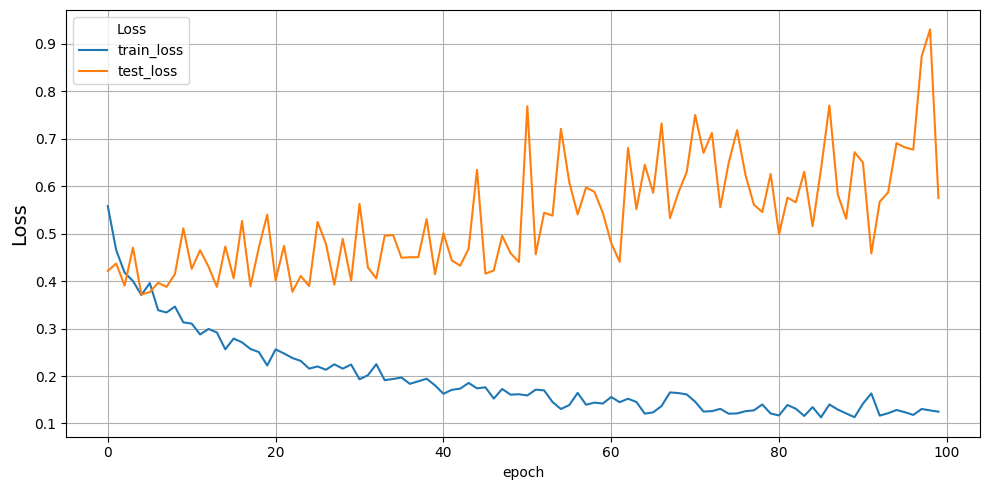

In [5]:
plot_wandb_training_curves("corflow-series_selection")